In [12]:
from model.MNIST_bin_MLP import load_BinMLP

In [13]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_BinMLP('./param/MNIST_bin_MLP.pth', device=device)

/home/henry/Desktop/USAAIO/inference/model/MNIST_bin_MLP.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

old_X, old_y = mnist.data, mnist.target
mask = (old_y == '0') | (old_y == '1')
X, y = old_X[mask], old_y[mask].astype("int64")

split = int(len(X) * 6 / 7)

test_X_half = torch.from_numpy(X[split:]).float().to(device) / 255
test_y_half = torch.from_numpy(y[split:]).float().view(-1, 1).to(device)

test_perm = torch.randperm(len(test_X_half) * 2)
test_X = torch.vstack((test_X_half, 1 - test_X_half))[test_perm]
test_y = torch.vstack((test_y_half, test_y_half))[test_perm]

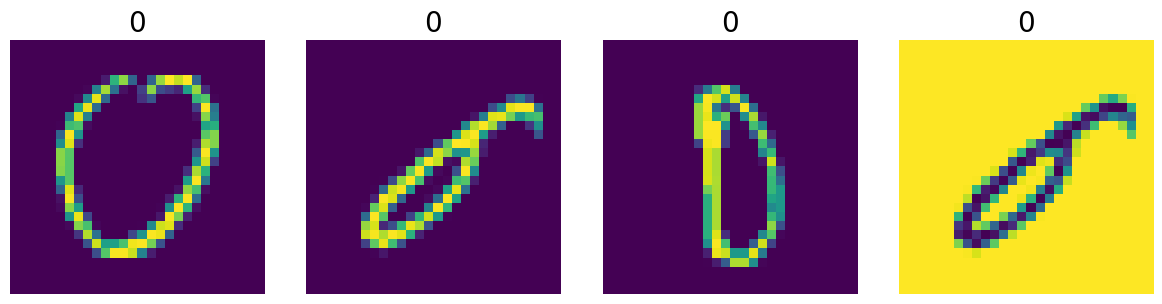

In [15]:
wrongInd = []

model.eval()
with torch.no_grad():
    preds = torch.round(model(test_X))
    preds = preds
    labels = test_y
    for i in range(len(test_X)):
        if preds[i].item() != labels[i].item():
            wrongInd.append(i)

import matplotlib.pyplot as plt

cols = 4
rows = (len(wrongInd) + cols - 1) // cols
plt.figure(figsize=(cols * 3, rows * 3))

for i, idx in enumerate(wrongInd):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(test_X[idx].view(28, 28).cpu())
    plt.axis('off')
    plt.title(int(test_y[idx].item()), fontsize=20)

plt.tight_layout()
plt.show()

In [16]:
tp, tn, fp, fn, wrong = 0, 0, 0, 0, 0
forward = torch.round(model.forward(test_X))

for i in range(len(test_X)):
    if test_y[i].item() == 0:
        if forward[i].item() == 0:
            tn += 1 # Predicted negative. Prediction is true.
        else:
            fp += 1 # Predicted positive. Prediction is false.
    else:
        if forward[i].item() == 0:
            fn += 1 # Predicted negative. Prediction is false.
        else:
            tp += 1 # Predicted positive. Prediction is true.

# Safe divisions
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

print(f'Accuracy (fraction correct): {accuracy:.4f}')
print(f'Precision (out of predicted positives, correct): {precision:.4f}')
print(f'Recall (out of actual positives, caught): {recall:.4f}')
print(f'F1 score (harmonic mean of precision/recall): {f1:.4f}')

Accuracy (fraction correct): 0.9991
Precision (out of predicted positives, correct): 0.9982
Recall (out of actual positives, caught): 1.0000
F1 score (harmonic mean of precision/recall): 0.9991


This is a 0 and a 1


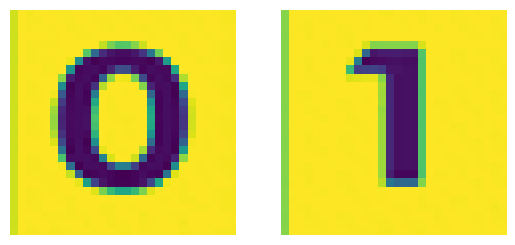

In [17]:
from PIL import Image
import torch
import numpy as np

zero = './images/zero.png'
one = './images/one.png'
img_zero = Image.open(zero).convert('L').resize((28, 28))
img_one = Image.open(one).convert('L').resize((28, 28))
tensor_zero = torch.from_numpy(np.array(img_zero).astype(np.float32)).float().to(device) / 255
tensor_one = torch.from_numpy(np.array(img_one).astype(np.float32)).float().to(device) / 25

plt.subplot(1, 2, 1)
plt.imshow(tensor_zero.cpu())
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tensor_one.cpu())
plt.axis('off')

print(f'This is a {int(round(model(tensor_zero.view(1, -1)).item()))} and a {int(round(model(tensor_one.view(1, -1)).item()))}')